In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils_CNN as utils

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-08-22 10:17:05.565278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 10:17:05.646710: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Sampling datasets

In [2]:
def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y == 1).sum()
        nb = (y == 0).sum()
    else:
        ns = (y.argmax(axis=1) == 1).sum()
        nb = (y.argmax(axis=1) == 0).sum()
    print(ns, nb)
    return ns, nb

In [3]:
config_file = 'config_files/image_pT_normalize_ZN_data_25x25_config_20.json'

In [4]:
# Read config file
with open(config_file, 'r') as f:
    config = json.load(f)

# train_npy_paths = config['train_npy_paths']
# val_npy_paths = config['val_npy_paths']
train_npy_path = config['train_npy_path']
val_npy_path = config['val_npy_path']
ns = config['ns']
seed = config['seed']
sensitivity = config['sensitivity']
luminosity = config['luminosity']

true_label_path = config['true_label_path']
model_name = config['model_name']
sample_type = config['sample_type']

# Sampling dataset
r_train, r_val = 0.8, 0.2
# n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity, L=luminosity)

# train_nevents = int(n_SR_S * r_train), int(n_SB_S * r_train), int(n_SR_B * r_train), int(n_SB_B * r_train)
# X_train, y_train = utils.create_mix_sample_from_npy(train_npy_paths, train_nevents, seed=seed)

# val_nevents = int(n_SR_S * r_val), int(n_SB_S * r_val), int(n_SR_B * r_val), int(n_SB_B * r_val)
# X_val, y_val = utils.create_mix_sample_from_npy(val_npy_paths, val_nevents, seed=seed)

n_SR_S, n_SR_B, n_SB_S, n_SB_B = ns
X_train, y_train = utils.load_samples(train_npy_path)
X_val, y_val = utils.load_samples(val_npy_path)

In [5]:
get_sample_size(y_train)
get_sample_size(y_val)

16800 17006
4200 4252


(4200, 4252)

In [6]:
# def image_pt_normlization(X):
#     # input shape: (n, res, res, 2)
#     return (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)


def event_pt_normlization(X):
    # input shape: (n, res, res, 2)
    return (X - X.mean(axis=(1, 2, 3), keepdims=True)) / X.std(axis=(1, 2, 3), keepdims=True)


def image_pt_normlization(X):
    # input shape: (n, res, res, 2)
    mean = np.mean(X, axis=(1, 2), keepdims=True)
    std = np.std(X, axis=(1, 2), keepdims=True)
    epsilon = 1e-8
    std = np.where(std < epsilon, epsilon, std)
    return (X - mean) / std

In [7]:
X_train = image_pt_normlization(X_train)
X_val = image_pt_normlization(X_val)

In [8]:
BATCH_SIZE = 512
with tf.device('CPU'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(BATCH_SIZE)

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(BATCH_SIZE)

2024-08-22 10:17:15.967907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 10:17:16.571349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


## CNN

In [9]:
class CNN(tf.keras.Model):
    def __init__(self, name='CNN'):
        super(CNN, self).__init__(name=name)

        self.bn1 = tf.keras.layers.BatchNormalization()

        self.bn2 = tf.keras.layers.BatchNormalization()

        self.sub_network = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    @tf.function
    def call(self, inputs, training=False):
        # split two channels
        channel1, channel2 = tf.split(inputs, num_or_size_splits=2, axis=-1)

        # pass through the same CNN
        channel1 = self.bn1(channel1)
        channel2 = self.bn2(channel2)
        output_channel1 = self.sub_network(channel1)
        output_channel2 = self.sub_network(channel2)

        # multiply the output
        output = tf.multiply(output_channel1, output_channel2)

        return output

In [10]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1])
        self.testing_loss.append(results[0])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0])
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()


class ROCCallback(tf.keras.callbacks.Callback):
    def __init__(self, testing_data):
        super(ROCCallback, self).__init__()
        self.testing_data = testing_data
        self.save_path = './figures/HVmodel_roc_curve'
    
    def set_save_path(self, path):
        self.save_path = path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            val_loss = logs.get('val_loss')
            print(f'Validation loss at epoch {epoch}: {val_loss:.3f}')

            x_test, y_test = self.testing_data
            y_pred = self.model.predict(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            
            # plot ROC curve
            fig, ax = plt.subplots(1,1, figsize=(5,4))
            ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, Loss = {val_loss:.3f}')
            ax.plot([0, 1], [0, 1], 'k--')

            ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC curve - Epoch {epoch+1}')
            ax.legend(frameon=False, fontsize=9)

            plt.savefig(f'{self.save_path}_ep{epoch+1}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
            plt.close(fig)


class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [11]:
sample_dir = true_label_path
test_data = utils.load_samples(sample_dir)

testing_callback = MyTestingCallback(test_data)
# roc_callback = ROCCallback(test_data)
loss_history = LossHistory()

# roc_callback.set_save_path('./figures/HVmodel_roc_curve_origin_split_val')

In [12]:
# Training parameters
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-4                                    
save_model_name = f'CNN_models/last_model_CNN/'

In [ ]:
# Create the model  
model = CNN()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=train_epochs,
                    callbacks=[early_stopping,
                               check_point,
                            #    testing_callback,
                            #    roc_callback,
                               loss_history
                               ]
                    )

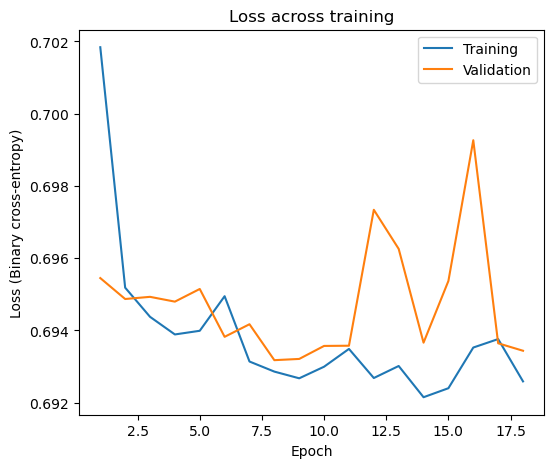

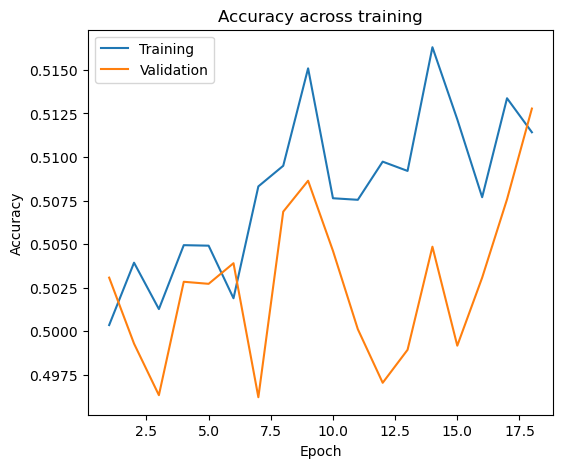

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend()

plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

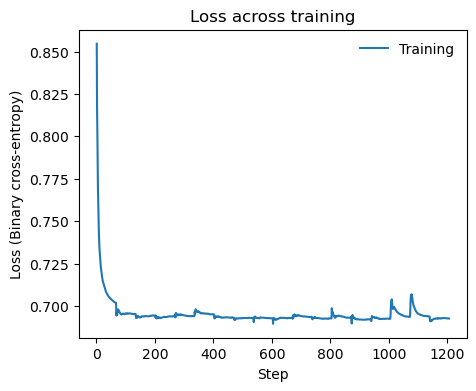

In [15]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(loss_history.losses) + 1)
y_train = loss_history.losses
# y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
# ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
# ax.set_xlim(1000, 3000)
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.show()

ValueError: x and y must have same first dimension, but have shapes (24,) and (0,)

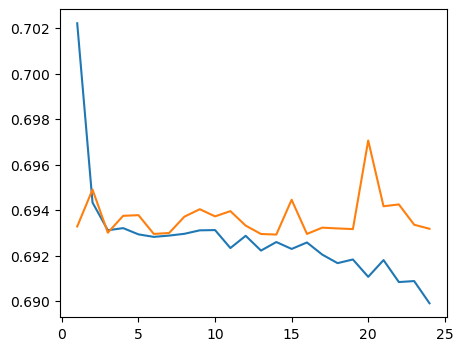

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']
y_testing = testing_callback.testing_loss

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')
ax.plot(x, y_testing, label='Testing')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False,)

# plt.savefig('../figures/HVmodel_loss_curve_copy_1_SB_3_res_75_split_val.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']
y_testing = testing_callback.testing_accuracy

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')
ax.plot(x, y_testing, label='Testing')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False,)

# plt.savefig('../figures/HVmodel_acc_curve_copy_1_SB_3_res_75_split_val.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Training results

## Model

In [16]:
save_model_name = f'CNN_models/last_model_CNN/'
loaded_model = tf.keras.models.load_model(save_model_name)

## Testing data

In [17]:
# sample_dir = f'../Sample/HVmodel/data/split_val/25x25/mix_sample_test.npy'
X_test, y_test = utils.load_samples(true_label_path)

X_test = image_pt_normlization(X_test)

results = loaded_model.evaluate(x=X_test, y=y_test, batch_size=BATCH_SIZE)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

79/79 [==============================] - 1s 8ms/step - loss: 0.6844 - accuracy: 0.6321
Testing Loss = 0.684, Testing Accuracy = 0.632
